In [1]:
# import required libraries
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import xgboost as xgb
from time import time
import os
PATH = "data/rossmann"
print(os.listdir(PATH))
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_palette("cubehelix", 8)#"deep")
from mlxtend.evaluate import feature_importance_permutation

['store.csv', 'test.csv', 'train.csv']


# Model Training

In [2]:
# read data
train = pd.read_csv(os.path.join(PATH,"train.csv"),parse_dates=[2], low_memory=False)
test = pd.read_csv(os.path.join(PATH,"test.csv"),parse_dates=[3], low_memory=False)
store = pd.read_csv(os.path.join(PATH,"store.csv"), low_memory=False)
test.fillna(1, inplace=True)
store.fillna(0, inplace=True)
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


## Preprocessing

In [3]:
def features_create(data):
    
    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
    data['CompetitionOpenSinceYear'] = data['CompetitionOpenSinceYear'].replace(1900.0, 0)
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data.loc[data['CompetitionOpen']>=2013*12,'CompetitionOpen'] = 0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0) 
    
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) +         (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data.loc[data['PromoOpen']>2013*12,'PromoOpen'] = 0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
  
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [4]:
train = features_create(train)
test = features_create(test)
train = train.sort_values('Date')
test = test.sort_values('Date')

In [5]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
1017208,1115,1,2013-01-01,0,0,0,0,1,1,4,...,2012.0,"Mar,Jun,Sept,Dec",2013,1,1,1,0.0,6.75,Jan,0
679363,746,1,2013-01-01,0,0,0,0,1,1,4,...,2011.0,"Mar,Jun,Sept,Dec",2013,1,1,1,23.0,15.50,Jan,0
155193,171,1,2013-01-01,0,0,0,0,1,1,1,...,0.0,,2013,1,1,1,0.0,0.00,Jan,0
632403,694,1,2013-01-01,0,0,0,0,1,1,1,...,2014.0,"Jan,Apr,Jul,Oct",2013,1,1,1,2.0,0.00,Jan,1
361623,396,1,2013-01-01,0,0,0,0,1,1,1,...,0.0,,2013,1,1,1,0.0,0.00,Jan,0


In [6]:
train = train[train['Open']!=0]
train.drop(['Date','PromoInterval','monthStr', 'Customers','Open', 'CompetitionOpenSinceMonth','Promo2SinceWeek'],axis=1,inplace =True)
#test.drop(['Date','PromoInterval','monthStr', 'Customers'],axis=1,inplace =True)

## Correlation Test

In [7]:
from sklearn.metrics import confusion_matrix

In [23]:
corr = train.corr(method='kendall')

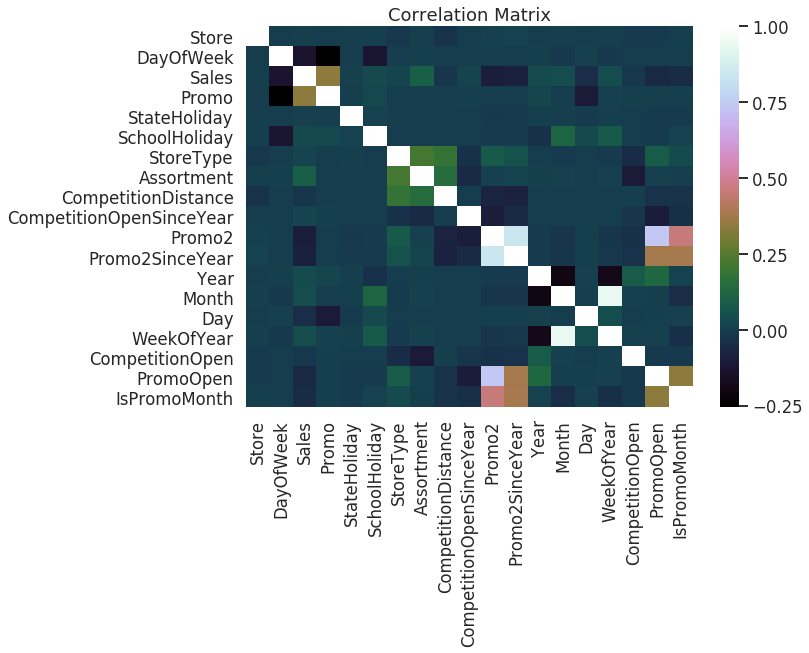

In [24]:
plt.figure(figsize=(10,7))
sns.heatmap(corr,cmap='cubehelix')
plt.title('Correlation Matrix')
plt.show()

In [13]:
corr

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
Store,1.000000,0.000346,0.007710,-0.000012,0.002042,0.000512,-0.021149,0.005727,-0.027117,-0.009339,0.007736,0.007768,0.000301,0.001365,-0.000119,0.001292,-0.012619,-0.014575,0.003853
DayOfWeek,0.000346,1.000000,-0.178736,-0.289265,-0.002699,-0.139315,-0.001971,0.001202,0.005536,-0.001300,-0.003241,-0.003238,0.002102,-0.019723,0.008534,-0.014402,-0.002379,-0.004786,-0.001287
Sales,0.007710,-0.178736,1.000000,0.368145,0.020107,0.038617,-0.016161,0.109030,-0.035469,0.004569,-0.127596,-0.127621,0.036169,0.073600,-0.051849,0.074472,-0.012402,-0.061068,-0.068069
Promo,-0.000012,-0.289265,0.368145,1.000000,-0.002418,0.028964,0.000335,-0.000328,-0.002394,0.001006,-0.000324,-0.000326,0.023994,-0.006408,-0.126452,0.006950,0.003240,0.006636,0.002981
StateHoliday,0.002042,-0.002699,0.020107,-0.002418,1.000000,0.022888,-0.004434,-0.000626,0.007089,-0.005092,-0.010152,-0.010147,0.000934,0.005277,-0.003289,0.005630,-0.002460,-0.010258,-0.006258
SchoolHoliday,0.000512,-0.139315,0.038617,0.028964,0.022888,1.000000,-0.002269,-0.002728,-0.004244,0.000195,-0.008245,-0.008248,-0.038679,0.118485,0.038081,0.079604,0.000650,-0.006334,0.012866
StoreType,-0.021149,-0.001971,-0.016161,0.000335,-0.004434,-0.002269,1.000000,0.230836,0.073774,-0.063730,0.089333,0.089276,-0.001482,-0.007644,0.000270,-0.007318,-0.040348,0.090301,0.039496
Assortment,0.005727,0.001202,0.109030,-0.000328,-0.000626,-0.002728,0.230836,1.000000,0.150232,-0.120891,0.008466,0.008513,0.002012,0.008349,0.000107,0.008071,-0.103110,-0.025597,0.002542
CompetitionDistance,-0.027117,0.005536,-0.035469,-0.002394,0.007089,-0.004244,0.073774,0.150232,1.000000,0.000844,-0.140926,-0.140990,0.000639,0.003919,-0.000226,0.003727,-0.012013,-0.055495,-0.064391
CompetitionOpenSinceYear,-0.009339,-0.001300,0.004569,0.001006,-0.005092,0.000195,-0.063730,-0.120891,0.000844,1.000000,-0.100004,-0.099940,-0.000086,-0.000420,-0.000348,-0.000418,0.512083,-0.089844,-0.042754


In [80]:
train.head()

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
621467,682,1,3375,0,1,1,2,1,150.0,2006.0,0,0.0,2013,1,1,1,76.0,0.0,0
483619,530,1,2907,0,1,1,1,3,18160.0,0.0,0,0.0,2013,1,1,1,0.0,0.0,0
235513,259,1,6851,0,1,1,2,2,210.0,0.0,0,0.0,2013,1,1,1,0.0,0.0,0
238339,262,1,17267,0,1,1,2,1,1180.0,2013.0,0,0.0,2013,1,1,1,0.0,0.0,0
249459,274,1,3102,0,1,1,2,2,3640.0,0.0,1,2013.0,2013,1,1,1,0.0,0.0,1


In [81]:
split = 6*7*1115
train_train = train.iloc[split:]
train_test = train.iloc[:split]

In [82]:
xtrain = train_train.drop(['Sales'],axis=1)
ytrain = np.log1p(train_train.Sales)

xtest = train_test.drop(['Sales'],axis=1)
ytest = np.log1p(train_test.Sales)


In [83]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [84]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 10
          }
num_boost_round = 500

In [85]:
dtrain = xgb.DMatrix(xtrain, ytrain)
dvalid = xgb.DMatrix(xtest, ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

## Training

In [86]:
progress = {}
model = xgb.XGBRegressor(objective =  "reg:linear",
                         booster =  "gbtree",
                         eta =  0.03,
                         max_depth =  10,
                         subsample =  0.9,
                         colsample_bytree =  0.7,
                         silent =  1,
                         seed=   10,
                         n_jobs = 100,
                         n_estimators = 500).fit(xtrain, ytrain, eval_set= [(xtest,ytest)], eval_metric=rmspe_xg, callbacks=[xgb.callback.record_evaluation(progress)])#, eval_set= (xtest,ytest), eval_metric=rmspe_xg)

[0]	validation_0-rmse:7.35704	validation_0-rmspe:inf


/root/ba-bere/target/pymaven/envs/builder/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


[1]	validation_0-rmse:6.61627	validation_0-rmspe:inf
[2]	validation_0-rmse:5.95245	validation_0-rmspe:inf
[3]	validation_0-rmse:5.35276	validation_0-rmspe:inf
[4]	validation_0-rmse:4.81296	validation_0-rmspe:inf
[5]	validation_0-rmse:4.32965	validation_0-rmspe:inf
[6]	validation_0-rmse:3.89418	validation_0-rmspe:inf
[7]	validation_0-rmse:3.50054	validation_0-rmspe:inf
[8]	validation_0-rmse:3.14905	validation_0-rmspe:inf
[9]	validation_0-rmse:2.83289	validation_0-rmspe:inf
[10]	validation_0-rmse:2.54935	validation_0-rmspe:inf
[11]	validation_0-rmse:2.29297	validation_0-rmspe:inf
[12]	validation_0-rmse:2.06345	validation_0-rmspe:inf
[13]	validation_0-rmse:1.8566	validation_0-rmspe:inf
[14]	validation_0-rmse:1.67401	validation_0-rmspe:inf
[15]	validation_0-rmse:1.5086	validation_0-rmspe:inf
[16]	validation_0-rmse:1.36011	validation_0-rmspe:inf
[17]	validation_0-rmse:1.22974	validation_0-rmspe:inf
[18]	validation_0-rmse:1.1117	validation_0-rmspe:inf
[19]	validation_0-rmse:1.00698	validatio

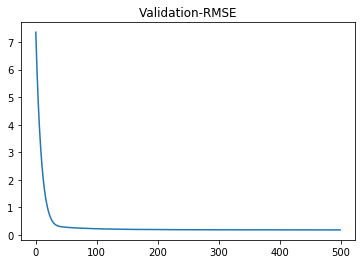

In [87]:
plt.plot(progress['validation_0']['rmse'])
plt.title('Validation-RMSE')
plt.show()


# SHAP Value Computation

In [15]:
xall = pd.concat([xtrain,xtest])
gt = np.concatenate([ytrain,ytest])

In [17]:
# explainer = shap.TreeExplainer(model)
# stores = xall['Store'].unique()
# start = time()
# store_data_list = []
# shap_value_list = []
# for i, store in enumerate(stores):
#     print(i, store)
#     store_data = xall[xall['Store']==store]
#     shap_values = explainer.shap_values(store_data)
#     store_data_list.append(store_data)
#     shap_value_list.append(shap_values)
#     if i%500 == 0:
#         shap_df = pd.DataFrame(shap_value_list)
#         shap_df.to_csv('shap_values_by_store2.csv')
#         shap_array = np.concatenate(shap_value_list, axis=0)
#         xtrain_by_stores = pd.concat(store_data_list)
#         xtrain_by_stores.to_csv('xtrain_by_store2.csv')
#         shap_array_df = pd.DataFrame(shap_array)
#         shap_array_df.to_csv('all_shap_values2.csv')
# end = time()
# print(end-start)
# shap_df = pd.DataFrame(shap_value_list)
# shap_df.to_csv('shap_values_by_store2.csv')
# shap_array = np.concatenate(shap_value_list, axis=0)
# xtrain_by_stores = pd.concat(store_data_list)
# xtrain_by_stores.to_csv('xtrain_by_store2.csv')
# shap_array_df = pd.DataFrame(shap_array)
# shap_array_df.to_csv('all_shap_values2.csv')

## FI Estimator Comparison

In [88]:
methods = ['gain', 'weight', 'cover', 'total_cover','total_gain']
fi_dict = {}
for method in methods:
    method_dict = model.get_booster().get_score(importance_type=method)
    fi_dict[method] = method_dict

fi_df = pd.DataFrame(fi_dict)
fi_df = fi_df[['gain', 'weight', 'cover', 'total_cover','total_gain']]
fi_df = fi_df.sort_values(by='gain',ascending=True)
fi_df

,gain,weight,cover,total_cover,total_gain
IsPromoMonth,0.166481,3379,4881.781296,1.649554e+07,562.538726
SchoolHoliday,0.186519,7713,6919.150006,5.336740e+07,1438.618483
WeekOfYear,0.404161,43204,4283.076174,1.850460e+08,17461.383034
Year,0.438358,14324,4077.049637,5.839966e+07,6279.033791
PromoOpen,0.482704,30993,6792.411641,2.105172e+08,14960.431638
Month,0.529339,24976,3160.979580,7.894863e+07,13220.769808
Day,0.529795,53392,4036.773992,2.155314e+08,28286.813742
CompetitionOpen,0.714577,31635,5507.844855,1.742407e+08,22605.653307
StateHoliday,0.732371,1205,16416.885477,1.978235e+07,882.506594
DayOfWeek,1.241911,38793,4396.738664,1.705627e+08,48177.468699


# Visualisations with SHAP

In [89]:
shap_array = pd.read_csv('rossmann_results/all_shap_values2.csv')
shap_array = shap_array.drop('Unnamed: 0',axis=1).values
xall_by_stores = pd.read_csv('rossmann_results/xtrain_by_store2.csv')

xall_by_stores = xall_by_stores.drop('Unnamed: 0',axis=1)

shap_df = pd.DataFrame(shap_array, columns= xall.columns)


stores = xall['Store'].unique()
# start = time()
gt_list = []
for i, store in enumerate(stores):

    gt_data = gt[xall['Store']==store]
    gt_list.append(gt_data)

gt_by_store = np.concatenate(gt_list)

xall_by_stores_dt = pd.to_datetime(xall_by_stores[['Year', 'Month','Day']])
xall_by_stores_dt.head()
preds = model.predict(xall_by_stores)

In [41]:
shap.initjs()

## Explaining Variance in Predictions

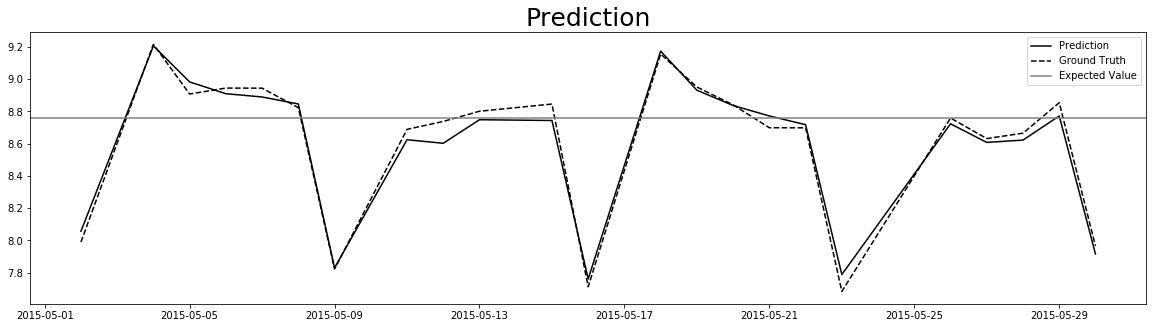

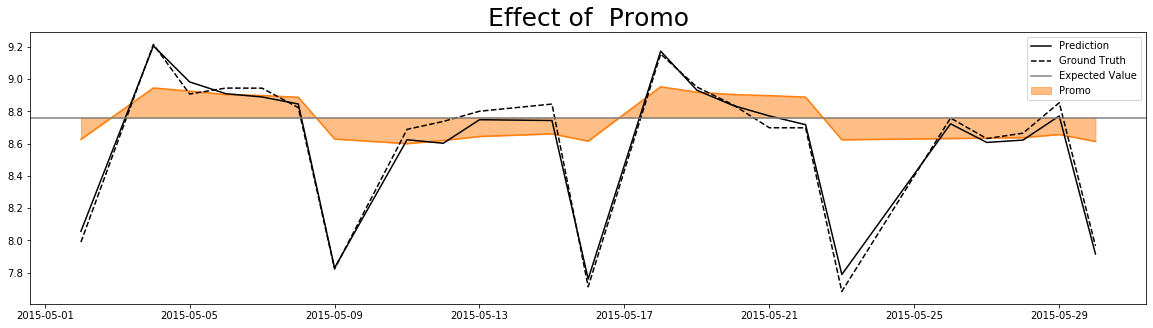

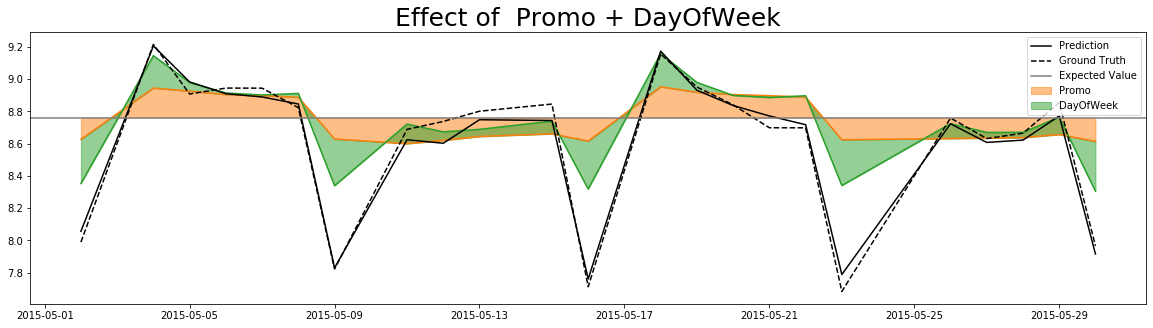

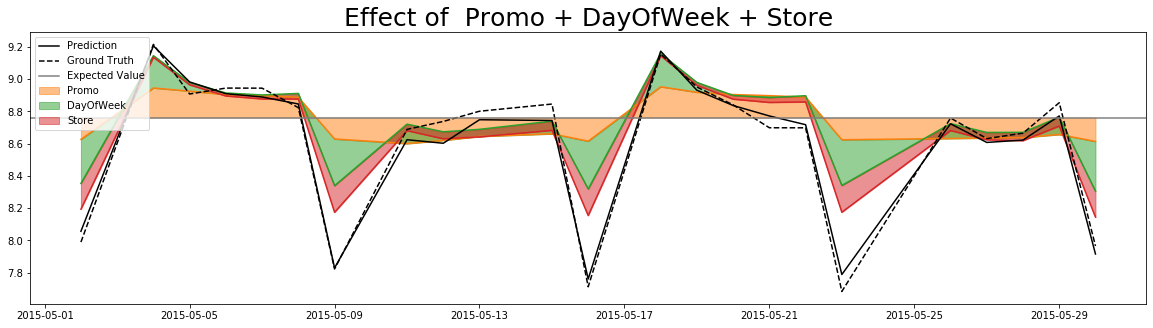

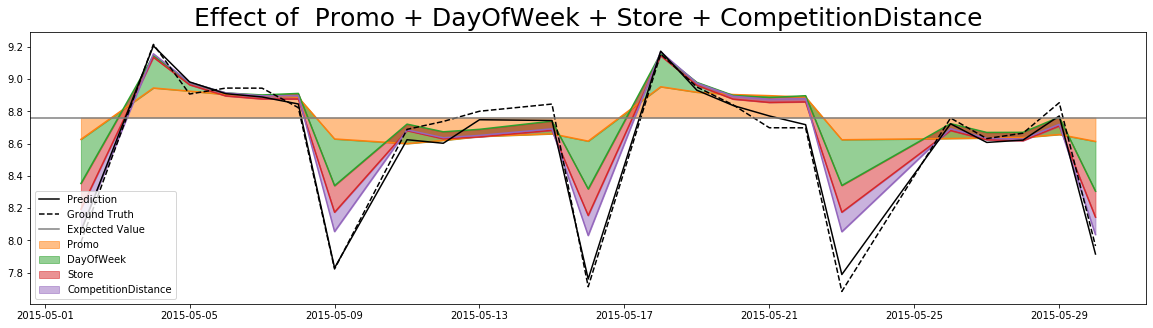

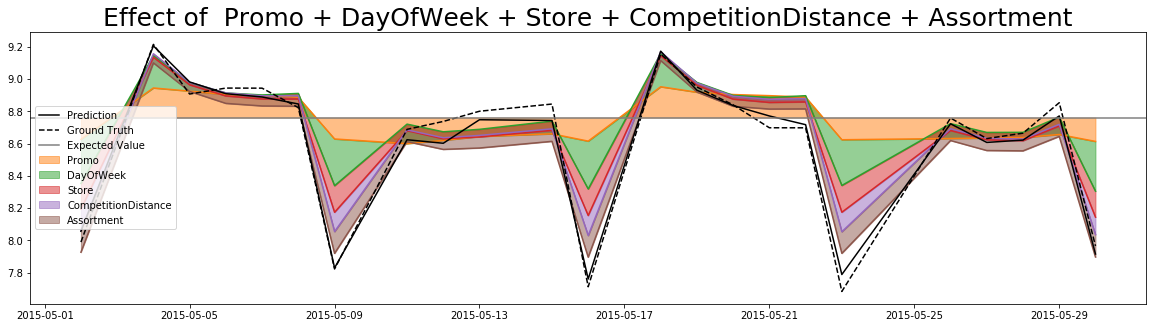

In [90]:
xall_by_stores_dt = pd.to_datetime(xall_by_stores[['Year', 'Month','Day']])
xall_by_stores_dt.head()
preds = model.predict(xall_by_stores)

store = stores[8]
year = 2015
month = [5]

stores = xall_by_stores['Store'].unique()
index = ((xall_by_stores['Store']== store) & (xall_by_stores['Year']==year) & (xall_by_stores['Month'].isin(month))).values

exp_value = 8.762

x = xall_by_stores_dt.loc[index].values
preds_index = preds[index]
gt_index = gt_by_store[index]

fz = (25,5)
fontz = 25
columns = ['Promo','DayOfWeek', 'Store','CompetitionDistance','Assortment']
plt.figure(figsize=(20,5))
plt.plot(x, preds_index, color='Black', label='Prediction')
plt.plot(x, gt_index, '--', color='Black', label='Ground Truth')
plt.axhline(exp_value, label='Expected Value', color='Gray')
plt.title('Prediction',fontsize=fontz)
plt.legend()
plt.show()
for j in range(len(columns)):
    
    plt.figure(figsize=(20,5))
    
    effects = exp_value
    title = ''
    for i, feature in enumerate(columns[:j+1]):
        if i==0:
            title += ' {}'.format(feature)
        else:
            title += ' + {}'.format(feature)
        effects_before = effects
        effects = effects + shap_df.loc[index,feature]
        plt.plot(x, effects, color='C{}'.format(i+1))#, color='Black', label='Prediction')
        
        plt.fill_between(x,effects_before,effects,color='C{}'.format(i+1), alpha=0.5, label=feature)
        
    plt.title('Effect of {}'.format(title),fontsize=fontz)
        
    plt.plot(x, preds_index, color='Black', label='Prediction')
    plt.plot(x, gt_index, '--', color='Black', label='Ground Truth')
    plt.axhline(exp_value, label='Expected Value', color='Gray')
    plt.legend()
    plt.show()


## Summary Plots

In [ ]:
for s in stores:
    if xall_by_stores[xall_by_stores['Store']== store]['CompetitionDistance'].iloc[0] != 0:
        print(s)
        break

In [106]:
store = 918#stores[10]
year = 2015
month = [6,7]
index = ((xall_by_stores['Store']== store) & (xall_by_stores['Year']==year) & (xall_by_stores['Month'].isin(month))).values
#index = ( (xall_by_stores['Year']==year) & (xall_by_stores['Month'].isin(month))).values

In [113]:
xall_by_stores.loc[index].head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
8168,918,0,1,0,0,1,3,18710.0,2015.0,0,0.0,2015,6,1,23,2.0,0.0,0
8169,918,1,1,0,0,1,3,18710.0,2015.0,0,0.0,2015,6,2,23,2.0,0.0,0
8170,918,2,1,0,0,1,3,18710.0,2015.0,0,0.0,2015,6,3,23,2.0,0.0,0
8171,918,3,1,1,0,1,3,18710.0,2015.0,0,0.0,2015,6,4,23,2.0,0.0,0
8172,918,4,1,0,0,1,3,18710.0,2015.0,0,0.0,2015,6,5,23,2.0,0.0,0


In [111]:
#shap_df.loc[index].head()
shap_df.loc[index].head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
8168,-0.041415,0.149166,0.174411,0.000269,0.002722,-0.024795,0.041528,-0.109626,-0.117263,0.006574,0.027319,0.038875,0.012018,0.105665,-0.000110,-0.030152,-0.011643,0.008043
8169,-0.037004,0.033805,0.144367,0.000175,0.002160,-0.022659,0.042745,-0.106501,-0.112722,0.010043,0.024682,0.033522,0.010911,0.089514,-0.000535,-0.028448,-0.009477,0.006171
8170,-0.032175,-0.004668,0.142539,0.000172,0.000303,-0.024757,0.049078,-0.122750,-0.105485,0.003880,0.026870,0.046461,0.006821,0.048439,0.003837,-0.026775,-0.011348,0.001883
8171,-0.022971,0.002360,0.190572,-0.112876,-0.002499,-0.032502,0.032985,-0.121320,-0.099462,0.002726,0.027623,0.037892,0.020963,0.037104,-0.011180,-0.022148,-0.010892,-0.000071
8172,-0.031023,0.036387,0.127377,0.000177,-0.002392,-0.034278,0.050504,-0.112657,-0.105927,0.003474,0.024675,0.039164,0.008139,0.021155,-0.000144,-0.030423,-0.011972,-0.000838


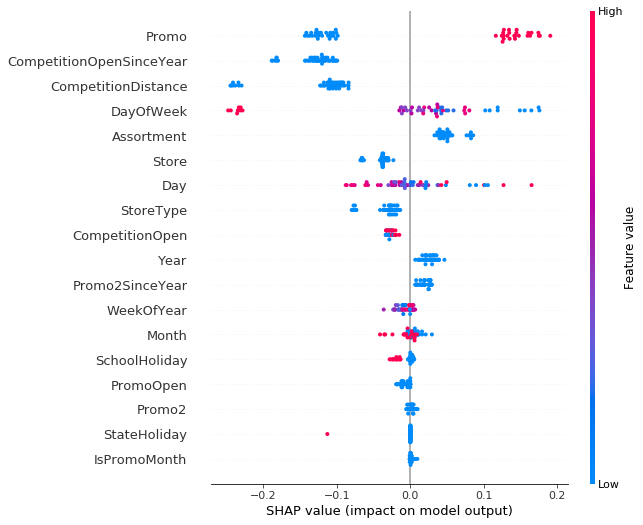

In [109]:
shap.summary_plot(shap_df.loc[index].values, xall_by_stores.loc[index])

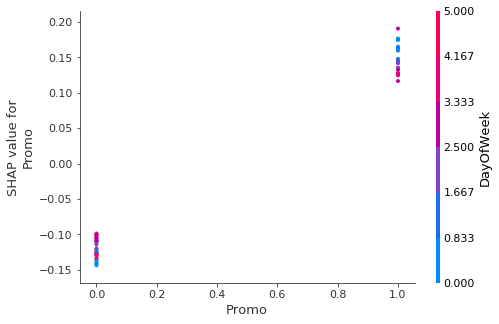

In [116]:
shap.dependence_plot('Promo',shap_df.loc[index].values, xall_by_stores.loc[index])

In [117]:
# shap.summary_plot(shap_df.values, xall_by_stores)

### Exemplary Comparison of different feature importance values distribution

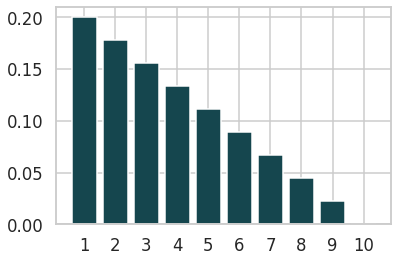

In [27]:
x = np.arange(10)
y = 10-np.arange(0,10)
x0 = x/x.sum()
plt.bar(y,x0, color='C1')
plt.xticks(np.arange(10)+1,np.arange(10)+1)
plt.show()

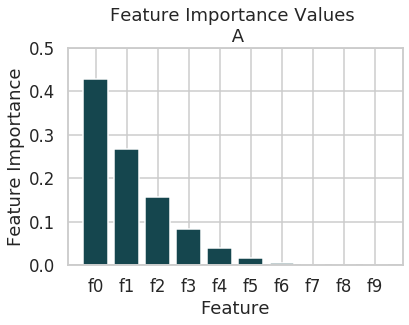

In [34]:
x1 = x**4
x1 = x1 / x1.sum()
plt.bar(y,x1, color='C1')
plt.ylim(0,0.5)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.xticks(np.arange(10)+1,['f{}'.format(i) for i in np.arange(10)])
plt.title('Feature Importance Values \n A')
plt.show()

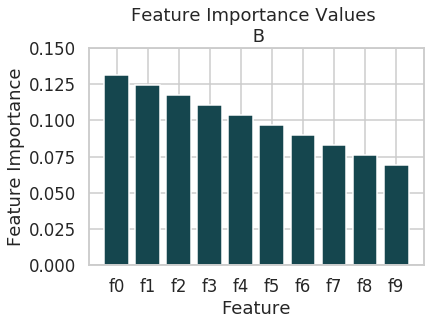

In [35]:
x2 = np.arange(5,10,0.5)
x2 = x2 / x2.sum()
plt.bar(y,x2, color='C1')
plt.ylim(0,0.15)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.xticks(np.arange(10)+1,['f{}'.format(i) for i in np.arange(10)])
plt.title('Feature Importance Values \n B')
plt.show()